***-----------------Old Data flux threshold 3e20------------------*** 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import datetime

# Load data column-wise
data_C24 = np.genfromtxt(
    "/home/rambahadur/Solar/Analysis/2025/track_info_all_25.txt", 
    dtype=None, encoding="utf-8", 
    delimiter=None, skip_header=1, unpack=True  # <== Reads column-wise
)

# Extract date column and convert to datetime
date_strings = [str(d.split('_')[0]) for d in data_C24[0]]  # First column contains date
date_C24 = [datetime.datetime.strptime(d, "%Y-%m-%dT%H:%M:%S.%f") for d in date_strings]

# Extract numeric columns (corrected indexing)
bmr_id = data_C24[1].astype(int)  # Second column: BMR ID
Lat_P_values = data_C24[2]        # Third column: Latitude of positive pole
Lat_M_values = data_C24[3]        # Fourth column: Latitude of negative pole
Lon_P_values = data_C24[4]        # Fifth column: Longitude of positive pole
Lon_M_values = data_C24[5]        # Sixth column: Longitude of negative pole
Flux_P_values = data_C24[6]       # Seventh column: Positive flux
Flux_M_values = data_C24[7]       # Eighth column: Negative flux

# Filter out zero flux values
mask = (Flux_P_values != 0) & (Flux_M_values != 0)
Flux_P_values, Flux_M_values = Flux_P_values[mask], Flux_M_values[mask]
Lon_P_values, Lat_P_values = Lon_P_values[mask], Lat_P_values[mask]
Lon_M_values, Lat_M_values = Lon_M_values[mask], Lat_M_values[mask]
date_C24, bmr_id = np.array(date_C24)[mask], bmr_id[mask]
unique_ids = np.unique(bmr_id)

# Dictionaries for storing results
mean_Flux_P, mean_Flux_M = {}, {}
mean_Lon_P, mean_Lon_M = {}, {}
mean_Lat_P, mean_Lat_M = {}, {}
first_date_C24 = {}
mean_total_flux = {}
# Compute mean values for each BMR
for uid in unique_ids:
    mask = (bmr_id == uid)
    
    # Calculate total unsigned flux for entire dataset
    total_flux = np.abs(Flux_P_values) + np.abs(Flux_M_values)
   
    # Consider maximum flux only if it appears within ±55° longitude
    within_55_mask = mask & (np.abs(Lon_P_values) <= 55) & (np.abs(Lon_M_values) <= 55)
    if not np.any(within_55_mask):
        continue
    
    # Get maximum total flux within ±55°
    max_total_flux = np.max(total_flux[within_55_mask])
    
    # Time period where total flux > 80% of maximum (for this BMR)

    valid_mask = mask & (total_flux > 0.8 * max_total_flux)
    # Store first occurrence date (any appearance within tracking)
    first_date_mask = mask & (date_C24 == np.min(date_C24[mask]))
    first_date_C24[uid] = date_C24[first_date_mask][0] if np.any(first_date_mask) else None
    
    # Calculate mean values during high-flux period
    if np.any(valid_mask):  # Only proceed if we have valid data
        mean_Flux_P[uid] = np.mean(Flux_P_values[valid_mask])
        mean_Flux_M[uid] = np.mean(Flux_M_values[valid_mask])
        mean_Lon_P[uid] = np.mean(Lon_P_values[valid_mask])
        mean_Lon_M[uid] = np.mean(Lon_M_values[valid_mask])
        mean_Lat_P[uid] = np.mean(Lat_P_values[valid_mask])
        mean_Lat_M[uid] = np.mean(Lat_M_values[valid_mask])
        mean_total_flux[uid] = np.mean(total_flux[valid_mask])



# Convert to NumPy arrays
Total_fluxE24 =  np.array(list(mean_total_flux.values()))
Flux_PEC24, Flux_MEC24 = np.array(list(mean_Flux_P.values())), np.array(list(mean_Flux_M.values()))
Lon_PE, Lon_ME = np.array(list(mean_Lon_P.values())), np.array(list(mean_Lon_M.values()))
Lat_PE, Lat_ME = np.array(list(mean_Lat_P.values())), np.array(list(mean_Lat_M.values()))
DateE_C24 = np.array(list(first_date_C24.values()))
# Convert dictionary keys (BMR IDs) to array
BMR_IDsE24 = np.array(list(mean_total_flux.keys()))


 # Mask for flux ≤ 2.9e20 (applied to full dataset)
flux_mask = Total_fluxE24 <= 3e20
Total_fluxE24=Total_fluxE24[flux_mask]
BMR_IDsE24 = BMR_IDsE24[flux_mask]
Flux_PEC24=Flux_PEC24[flux_mask]
Flux_MEC24=Flux_MEC24[flux_mask]
Lon_PE=Lon_PE[flux_mask]
Lon_ME=Lon_ME[flux_mask]
Lat_PE, Lat_ME=Lat_PE[flux_mask], Lat_ME[flux_mask]
DateE_C24=DateE_C24[flux_mask]
# After applying the flux_mask and filtering the variables, save the filtered data to a new file
print(len(BMR_IDsE24))
# Get the BMR IDs that passed the flux_mask
bmr_ids_filtered = np.array(list(mean_total_flux.keys()))[flux_mask]

413


***------------------------Save filter Data------------------------***

In [2]:

input_file = "/home/rambahadur/Solar/Analysis/2025/track_info_all_25.txt"
output_file = "/home/rambahadur/Solar/Analysis/2025/ner_er_track_info_all_25.txt"

# Reload the original data row-wise (each row as a list of strings)
with open(input_file, 'r') as f:
    header = f.readline()  # Save the header separately
    all_lines = f.readlines()

# Parse BMR IDs from each line (assumes BMR ID is the 2nd column, index 1)
parsed_lines = []
for line in all_lines:
    cols = line.strip().split()
    try:
        bmr = int(cols[1])  # Adjust index if BMR ID is in a different column
        parsed_lines.append((bmr, line))
    except (IndexError, ValueError):
        continue  # Skip malformed lines

# Filter lines where BMR ID is in bmr_ids_filtered
filtered_lines = [line for bmr, line in parsed_lines if bmr in bmr_ids_filtered]

# Save to new file
with open(output_file, 'w') as f:
    f.write(header)
    f.writelines(filtered_lines)

print(f"Saved {len(filtered_lines)} matching rows to '{output_file}'.")


Saved 2274 matching rows to '/home/rambahadur/Solar/Analysis/2025/ner_er_track_info_all_25.txt'.


***----------------------------cheking the  latest filter data with plot-----------------------------***

491


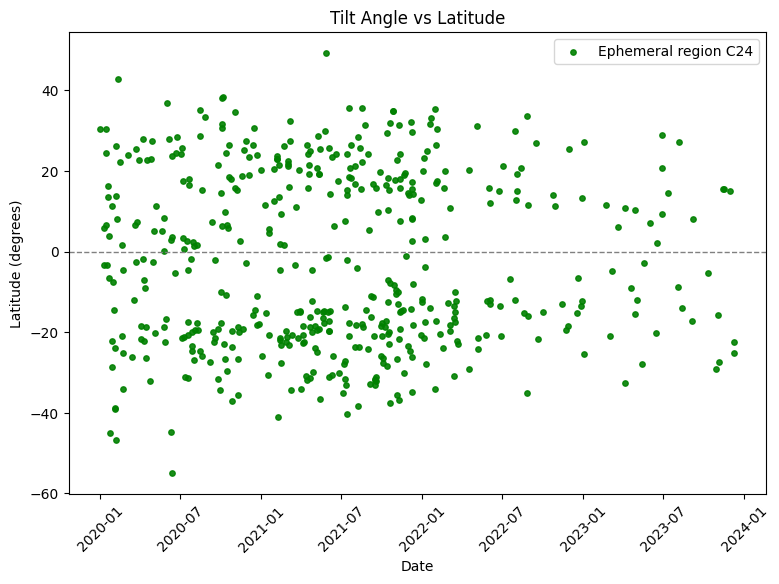

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import datetime

# Load data column-wise
data_C24 = np.genfromtxt(
    "/home/rambahadur/Solar/Analysis/2025/extracted_data_25.txt", 
    dtype=None, encoding="utf-8", 
    delimiter=None, skip_header=1, unpack=True  # <== Reads column-wise
)

# Extract date column and convert to datetime
date_strings = [str(d.split('_')[0]) for d in data_C24[0]]  # First column contains date
date_C24 = [datetime.datetime.strptime(d, "%Y-%m-%dT%H:%M:%S.%f") for d in date_strings]

# Extract numeric columns (corrected indexing)
bmr_id = data_C24[1].astype(int)  # Second column: BMR ID
Lat_P_values = data_C24[2]        # Third column: Latitude of positive pole
Lat_M_values = data_C24[3]        # Fourth column: Latitude of negative pole
Lon_P_values = data_C24[4]        # Fifth column: Longitude of positive pole
Lon_M_values = data_C24[5]        # Sixth column: Longitude of negative pole
Flux_values = data_C24[6]      

# Filter out zero flux values
mask = (Flux_values != 0)
Flux_values = Flux_values[mask]
Lon_P_values, Lat_P_values = Lon_P_values[mask], Lat_P_values[mask]
Lon_M_values, Lat_M_values = Lon_M_values[mask], Lat_M_values[mask]
date_C24, bmr_id = np.array(date_C24)[mask], bmr_id[mask]
unique_ids = np.unique(bmr_id)

# Dictionaries for storing results

mean_Lon_P, mean_Lon_M = {}, {}
mean_Lat_P, mean_Lat_M = {}, {}
first_date_C24 = {}
mean_total_flux = {}
# Compute mean values for each BMR
for uid in unique_ids:
    mask = (bmr_id == uid)
    
    # Calculate total unsigned flux for entire dataset
    total_flux = Flux_values   
    # Consider maximum flux only if it appears within ±55° longitude
    within_55_mask = mask & (np.abs(Lon_P_values) <= 55) & (np.abs(Lon_M_values) <= 55)
    if not np.any(within_55_mask):
        continue
    
    # Get maximum total flux within ±55°
    max_total_flux = np.max(total_flux[within_55_mask])
    
    # Time period where total flux > 80% of maximum (for this BMR)

    valid_mask = mask & (total_flux > 0.8 * max_total_flux)
    # Store first occurrence date (any appearance within tracking)
    first_date_mask = mask & (date_C24 == np.min(date_C24[mask]))
    first_date_C24[uid] = date_C24[first_date_mask][0] if np.any(first_date_mask) else None
    
    # Calculate mean values during high-flux period
    if np.any(valid_mask):  # Only proceed if we have valid data

        
        mean_Lon_P[uid] = np.mean(Lon_P_values[valid_mask])
        mean_Lon_M[uid] = np.mean(Lon_M_values[valid_mask])
        mean_Lat_P[uid] = np.mean(Lat_P_values[valid_mask])
        mean_Lat_M[uid] = np.mean(Lat_M_values[valid_mask])
        mean_total_flux[uid] = np.mean(total_flux[valid_mask])



# Convert to NumPy arrays
Total_fluxE24 =  np.array(list(mean_total_flux.values()))
Lon_PE, Lon_ME = np.array(list(mean_Lon_P.values())), np.array(list(mean_Lon_M.values()))
Lat_PE, Lat_ME = np.array(list(mean_Lat_P.values())), np.array(list(mean_Lat_M.values()))
DateE_C24 = np.array(list(first_date_C24.values()))
 # Mask for flux ≤ 2.9e20 (applied to full dataset)
flux_mask = Total_fluxE24 <= 2.9e4
Total_fluxE24=Total_fluxE24[flux_mask]
Lon_PE=Lon_PE[flux_mask]
Lon_ME=Lon_ME[flux_mask]
Lat_PE, Lat_ME=Lat_PE[flux_mask], Lat_ME[flux_mask]
DateE_C24=DateE_C24[flux_mask]

# Ensure sizes match
min_size = min(Lat_PE.size, Lat_ME.size)
Lon_PEC24, Lat_PEC24 = Lon_PE[:min_size], Lat_PE[:min_size]
Lon_MEC24, Lat_MEC24 = Lon_ME[:min_size], Lat_ME[:min_size]

#-----------------------------------------------
# Determine leading polarity
leading_is_positive = np.abs(Lon_PEC24) > np.abs(Lon_MEC24)
leading_is_negative = np.abs(Lon_PEC24) < np.abs(Lon_MEC24)
Lon_leadC24 = np.where(leading_is_positive, Lon_PEC24, Lon_MEC24)
Lat_leadC24 = np.where(leading_is_positive, Lat_PEC24, Lat_MEC24)
Lon_trailC24 = np.where(leading_is_positive, Lon_MEC24, Lon_PEC24)
Lat_trailC24 = np.where(leading_is_positive, Lat_MEC24, Lat_PEC24)
leading_is_negative = np.abs(Lon_PEC24) < np.abs(Lon_MEC24)
# Compute midpoint latitude
latitudeE_C24 = (Lat_leadC24 + Lat_trailC24) / 2

# Compute tilt angle
delta_Lon = Lon_leadC24 - Lon_trailC24
delta_Lat = Lat_leadC24 - Lat_trailC24
Colat_P = 90 - latitudeE_C24
sin_Colat_P = np.sin(np.radians(Colat_P))
tan_yC24 = np.divide(delta_Lat, delta_Lon * sin_Colat_P, where=(delta_Lon * sin_Colat_P) != 0)
yE_C24 = np.degrees(np.arctan(tan_yC24))

# --- Corrected Hale-Classification ---
#equator_threshold = 15  # Adjust as needed

# Identify if BMR is near or far from the equator
near_equator = np.abs(Lat_leadC24) < np.abs(Lat_trailC24)
far_from_equator = ~near_equator  

# Determine polarity relationship correctly
#lead_positive = Flux_PC24 > np.abs(Flux_MC24)  # If leading polarity has more +flux
#lead_negative = Flux_MC24 > np.abs(Flux_PC24)  # If leading polarity has more -flux

# Categorize BMRs
hale_joy = leading_is_negative & near_equator
anti_hale_joy = leading_is_positive & near_equator
hale_anti_joy = leading_is_negative & far_from_equator
anti_hale_anti_joy = leading_is_positive & far_from_equator

# Initialize corrected ycor_C24
ycorE_C24 = yE_C24.copy()

# Apply conditions for tilt correction
ycorE_C24[hale_joy | anti_hale_anti_joy] = np.abs(yE_C24[hale_joy | anti_hale_anti_joy])  # Ensure positive tilt
ycorE_C24[anti_hale_joy | hale_anti_joy] = -np.abs(yE_C24[anti_hale_joy | hale_anti_joy])  # Ensure negative tilt

# Print categories for verification
#print("Hale-Joy:", hale_joy)
#print("AntiHale-Joy:", anti_hale_joy)
#print("Hale-AntiJoy:", hale_anti_joy)
#print("AntiHale-AntiJoy:", anti_hale_anti_joy)
#print("Corrected ycor_C24:", ycor_C24)

# Separate hemispheres
north_hemi = latitudeE_C24 >= 0
south_hemi = latitudeE_C24 < 0
latitudeE_north24, yE_north24 = latitudeE_C24[north_hemi], ycorE_C24[north_hemi]
latitudeE_south24, yE_south24 = -latitudeE_C24[south_hemi], -ycorE_C24[south_hemi]
print(len(ycorE_C24))
#-----------------------------------------------
# Plot
plt.figure(figsize=(9, 6))
plt.scatter(DateE_C24, latitudeE_C24, marker="o", color="g", s=15, alpha=0.9, label="Ephemeral region C24")
plt.xlabel("Date")
plt.ylabel("Latitude (degrees)")
plt.title("Tilt Angle vs Latitude")
plt.axhline(0, color="gray", linestyle="--", linewidth=1)
plt.legend()
plt.xticks(rotation=45)
plt.show()


***-----------------apply flux threshold filter on the latest updated autoTAB data ---------------------------***

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import datetime

# Load data column-wise
data_C24 = np.genfromtxt(
    "/home/rambahadur/Solar/Analysis/2023/extracted_data_23.txt", 
    dtype=None, encoding="utf-8", 
    delimiter=None, skip_header=1, unpack=True  # <== Reads column-wise
)

# Extract date column and convert to datetime
date_strings = [str(d.split('_')[0]) for d in data_C24[0]]  # First column contains date
date_C24 = [datetime.datetime.strptime(d, "%Y-%m-%dT%H:%M:%S.%f") for d in date_strings]

# Extract numeric columns (corrected indexing)
bmr_id = data_C24[1].astype(int)  # Second column: BMR ID
Lat_P_values = data_C24[2]        # Third column: Latitude of positive pole
Lat_M_values = data_C24[3]        # Fourth column: Latitude of negative pole
Lon_P_values = data_C24[4]        # Fifth column: Longitude of positive pole
Lon_M_values = data_C24[5]        # Sixth column: Longitude of negative pole
Flux_values = data_C24[6]      
# Filter out zero flux values
mask = (Flux_values != 0) 
Flux_values = Flux_values[mask]
Lon_P_values, Lat_P_values = Lon_P_values[mask], Lat_P_values[mask]
Lon_M_values, Lat_M_values = Lon_M_values[mask], Lat_M_values[mask]
date_C24, bmr_id = np.array(date_C24)[mask], bmr_id[mask]
unique_ids = np.unique(bmr_id)

# Dictionaries for storing results
mean_Flux_P, mean_Flux_M = {}, {}
mean_Lon_P, mean_Lon_M = {}, {}
mean_Lat_P, mean_Lat_M = {}, {}
first_date_C24 = {}
mean_total_flux = {}
# Compute mean values for each BMR
for uid in unique_ids:
    mask = (bmr_id == uid)
    
    total_flux = Flux_values   
   
     # 1. Max flux of BMR only within ±55°
    within_55_mask = mask & (np.abs(Lon_P_values) <= 55) & (np.abs(Lon_M_values) <= 55)

    if not np.any(within_55_mask):
        continue  # skip this BMR if it never entered the ±55° range

    max_total_flux = np.max(Flux_values[within_55_mask])

    # 2. Get time period where flux > 80% of that max, across all times
    high_flux_mask = mask & (Flux_values > 0.8 * max_total_flux)

    # 3. Now restrict to those entries ALSO within ±55°
    valid_mask = high_flux_mask & (np.abs(Lon_P_values) <= 55) & (np.abs(Lon_M_values) <= 55)

    if not np.any(valid_mask):
        continue  # skip if no valid samples

    # Proceed with averaging
    # Store first occurrence date (any appearance within tracking)
    first_date_mask = mask & (date_C24 == np.min(date_C24[mask]))
    first_date_C24[uid] = date_C24[first_date_mask][0] if np.any(first_date_mask) else None
    
    # Calculate mean values during high-flux period
    if np.any(valid_mask):  # Only proceed if we have valid data
    
        mean_Lon_P[uid] = np.mean(Lon_P_values[valid_mask])
        mean_Lon_M[uid] = np.mean(Lon_M_values[valid_mask])
        mean_Lat_P[uid] = np.mean(Lat_P_values[valid_mask])
        mean_Lat_M[uid] = np.mean(Lat_M_values[valid_mask])
        mean_total_flux[uid] = np.mean(total_flux[valid_mask])



# Convert to NumPy arrays
Total_fluxE24 =  np.array(list(mean_total_flux.values()))
Lon_PE, Lon_ME = np.array(list(mean_Lon_P.values())), np.array(list(mean_Lon_M.values()))
Lat_PE, Lat_ME = np.array(list(mean_Lat_P.values())), np.array(list(mean_Lat_M.values()))
DateE_C24 = np.array(list(first_date_C24.values()))
# Convert dictionary keys (BMR IDs) to array
BMR_IDsE24 = np.array(list(mean_total_flux.keys()))


 # Mask for flux ≤ 2.9e20 (applied to full dataset)
flux_mask = Total_fluxE24 <= 2.99e4
Total_fluxE24=Total_fluxE24[flux_mask]
BMR_IDsE24 = BMR_IDsE24[flux_mask]
Lon_PE=Lon_PE[flux_mask]
Lon_ME=Lon_ME[flux_mask]
Lat_PE, Lat_ME=Lat_PE[flux_mask], Lat_ME[flux_mask]
DateE_C24=DateE_C24[flux_mask]
# After applying the flux_mask and filtering the variables, save the filtered data to a new file
print(len(BMR_IDsE24))
# Get the BMR IDs that passed the flux_mask
bmr_ids_filtered = np.array(list(mean_total_flux.keys()))[flux_mask]

535


***-----------------------------Save filtered data ------------------------***

In [2]:

input_file = "/home/rambahadur/Solar/Analysis/2023/extracted_data_23.txt"
output_file = "/home/rambahadur/Solar/F299_extracted_data_23.txt"

# Reload the original data row-wise (each row as a list of strings)
with open(input_file, 'r') as f:
    header = f.readline()  # Save the header separately
    all_lines = f.readlines()

# Parse BMR IDs from each line (assumes BMR ID is the 2nd column, index 1)
parsed_lines = []
for line in all_lines:
    cols = line.strip().split()
    try:
        bmr = int(cols[1])  # Adjust index if BMR ID is in a different column
        parsed_lines.append((bmr, line))
    except (IndexError, ValueError):
        continue  # Skip malformed lines

# Filter lines where BMR ID is in bmr_ids_filtered
filtered_lines = [line for bmr, line in parsed_lines if bmr in bmr_ids_filtered]

# Save to new file
with open(output_file, 'w') as f:
    f.write(header)
    f.writelines(filtered_lines)

print(f"Saved {len(filtered_lines)} matching rows to '{output_file}'.")


Saved 3833 matching rows to '/home/rambahadur/Solar/F299_extracted_data_23.txt'.


***----------------------------Footpoint thereshold 35 MM applied on data and save file -----------------***

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import datetime
import os

input_file = "/home/rambahadur/Solar/F299_extracted_data_23.txt"
output_file = "/home/rambahadur/Solar/FF29_extracted_data_23.txt"
#sav_dir = '/home/rambahadur/Solar/Analysis_ERs/C24'

# Load column-wise data
data_C24 = np.genfromtxt(
    input_file, dtype=None, encoding="utf-8", 
    delimiter=None, skip_header=1, unpack=True
)

# Extract date and numeric columns
date_strings = [str(d.split('_')[0]) for d in data_C24[0]]
date_C24 = [datetime.datetime.strptime(d, "%Y-%m-%dT%H:%M:%S.%f") for d in date_strings]

bmr_id = data_C24[1].astype(int)
Lat_P_values = data_C24[2]
Lat_M_values = data_C24[3]
Lon_P_values = data_C24[4]
Lon_M_values = data_C24[5]
Flux_values = data_C24[6]*1e16

# Apply mask
flux_mask = (Flux_values != 0)
long_mask = (np.abs(Lon_P_values) <= 55) & (np.abs(Lon_M_values) <= 55)
combined_mask = flux_mask & long_mask

# Apply filtered mask
bmr_id = bmr_id[combined_mask]
Lat_P_values = Lat_P_values[combined_mask]
Lat_M_values = Lat_M_values[combined_mask]
Lon_P_values = Lon_P_values[combined_mask]
Lon_M_values = Lon_M_values[combined_mask]
Flux_values = Flux_values[combined_mask]
date_C24 = np.array(date_C24)[combined_mask]

# Analyze BMRs
unique_ids = np.unique(bmr_id)
all_norm_times = []
footpoint = []
init_footpoint = []
filtered_bmr_ids = []

for uid in unique_ids:
    mask = (bmr_id == uid)
    if np.sum(mask) < 2:
        continue

    lat1 = np.radians(Lat_P_values[mask])
    lat2 = np.radians(Lat_M_values[mask])
    lon1 = np.radians(Lon_P_values[mask])
    lon2 = np.radians(Lon_M_values[mask])
    
    dlon = lon2 - lon1
    D = 695700 * np.arccos(
        np.cos(lat1) * np.cos(lat2) * np.cos(dlon) + np.sin(lat1) * np.sin(lat2)
    ) / 1000  # in Mm

    D_0 = D[0]
    if D_0 >= 40:
        continue

    filtered_bmr_ids.append(uid)

    times_bmr = date_C24[mask]
    t0 = times_bmr[0]
    times_hours = (times_bmr - t0).astype('timedelta64[h]').astype(float)
    if np.max(times_hours) == 0:
        continue

    norm_times = times_hours / np.max(times_hours)

    all_norm_times.extend(norm_times)
    footpoint.extend(D)
    init_footpoint.append(D_0)

# Convert to arrays
filtered_bmr_ids = set(filtered_bmr_ids) #A set automatically eliminates duplicates.
all_norm_times24 = np.array(all_norm_times)
footpoint24 = np.array(footpoint)

# Re-parse original file line by line and filter
with open(input_file, 'r') as f: #It automatically closes the file after you're done reading.'r' means "open for reading."f.readline() reads one line — the very first one.
    header = f.readline()    #Keep the header (column names, metadata, etc.) unchanged.
    all_lines = f.readlines() #Load the rest of the file to process/filter line by line.

parsed_lines = []
for line in all_lines:
    cols = line.strip().split()
    try:
        bmr = int(cols[1])  # assuming 2nd column is BMR ID
        parsed_lines.append((bmr, line))
    except (IndexError, ValueError):
        continue

filtered_lines = [line for bmr, line in parsed_lines if bmr in filtered_bmr_ids]

with open(output_file, 'w') as f:
    f.write(header)
    f.writelines(filtered_lines)

print(f"✅ Saved {len(filtered_lines)} filtered rows (D₀ < 40) to: {output_file}")


✅ Saved 3193 filtered rows (D₀ < 40) to: /home/rambahadur/Solar/FF29_extracted_data_23.txt


***----------------------------Footpoint thereshold 25 MM applied on data and save file -----------------***

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import datetime
import os

input_file = "/home/rambahadur/Solar/Analysis/er_extracted_data_23.txt"
output_file = "/home/rambahadur/Solar/Analysis/new2_er_extracted_data_23.txt"
sav_dir = '/home/rambahadur/Solar/Analysis_ERs/C23'

# Load column-wise data
data_C24 = np.genfromtxt(
    input_file, dtype=None, encoding="utf-8", 
    delimiter=None, skip_header=1, unpack=True
)

# Extract date and numeric columns
date_strings = [str(d.split('_')[0]) for d in data_C24[0]]
date_C24 = [datetime.datetime.strptime(d, "%Y-%m-%dT%H:%M:%S.%f") for d in date_strings]

bmr_id = data_C24[1].astype(int)
Lat_P_values = data_C24[2]
Lat_M_values = data_C24[3]
Lon_P_values = data_C24[4]
Lon_M_values = data_C24[5]
Flux_values = data_C24[6]*1e16

# Apply mask
flux_mask = (Flux_values != 0)
long_mask = (np.abs(Lon_P_values) <= 55) & (np.abs(Lon_M_values) <= 55)
combined_mask = flux_mask & long_mask

# Apply filtered mask
bmr_id = bmr_id[combined_mask]
Lat_P_values = Lat_P_values[combined_mask]
Lat_M_values = Lat_M_values[combined_mask]
Lon_P_values = Lon_P_values[combined_mask]
Lon_M_values = Lon_M_values[combined_mask]
Flux_values = Flux_values[combined_mask]
date_C24 = np.array(date_C24)[combined_mask]

# Analyze BMRs
unique_ids = np.unique(bmr_id)
all_norm_times = []
footpoint = []
init_footpoint = []
filtered_bmr_ids = []

for uid in unique_ids:
    mask = (bmr_id == uid)
    if np.sum(mask) < 2:
        continue

    lat1 = np.radians(Lat_P_values[mask])
    lat2 = np.radians(Lat_M_values[mask])
    lon1 = np.radians(Lon_P_values[mask])
    lon2 = np.radians(Lon_M_values[mask])
    
    dlon = lon2 - lon1
    D = 695700 * np.arccos(
        np.cos(lat1) * np.cos(lat2) * np.cos(dlon) + np.sin(lat1) * np.sin(lat2)
    ) / 1000  # in Mm

    D_0 = D[0]
    if D_0 >= 25:
        continue

    filtered_bmr_ids.append(uid)

    times_bmr = date_C24[mask]
    t0 = times_bmr[0]
    times_hours = (times_bmr - t0).astype('timedelta64[h]').astype(float)
    if np.max(times_hours) == 0:
        continue

    norm_times = times_hours / np.max(times_hours)

    all_norm_times.extend(norm_times)
    footpoint.extend(D)
    init_footpoint.append(D_0)

# Convert to arrays
filtered_bmr_ids = set(filtered_bmr_ids)
all_norm_times24 = np.array(all_norm_times)
footpoint24 = np.array(footpoint)

# Re-parse original file line by line and filter
with open(input_file, 'r') as f:
    header = f.readline()
    all_lines = f.readlines()

parsed_lines = []
for line in all_lines:
    cols = line.strip().split()
    try:
        bmr = int(cols[1])  # assuming 2nd column is BMR ID
        parsed_lines.append((bmr, line))
    except (IndexError, ValueError):
        continue

filtered_lines = [line for bmr, line in parsed_lines if bmr in filtered_bmr_ids]

with open(output_file, 'w') as f:
    f.write(header)
    f.writelines(filtered_lines)

print(f"✅ Saved {len(filtered_lines)} filtered rows (D₀ < 25) to: {output_file}")


✅ Saved 2342 filtered rows (D₀ < 25) to: /home/rambahadur/Solar/Analysis/new2_er_extracted_data_23.txt


***------------------------2 Days life time filtered data------------------------***

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import datetime

# Load data column-wise
data_C25 = np.genfromtxt(
    "/home/rambahadur/Solar/FDATA/FF3_extracted_data_25.txt", 
    dtype=None, encoding="utf-8", 
    delimiter=None, skip_header=1, unpack=True
)

# Extract date column and convert to datetime
date_strings = [str(d.split('_')[0]) for d in data_C25[0]]
date_C25 = [datetime.datetime.strptime(d, "%Y-%m-%dT%H:%M:%S.%f") for d in date_strings]

# Extract numeric columns (corrected indexing)
bmr_id = data_C25[1].astype(int)
Lat_P_values = data_C25[2]
Lat_M_values = data_C25[3]
Lon_P_values = data_C25[4]
Lon_M_values = data_C25[5]
Flux_values = data_C25[6]*1e16


# Filter out zero flux values
mask = (Flux_values != 0) 
Flux_values = Flux_values[mask]
Lon_P_values, Lat_P_values = Lon_P_values[mask], Lat_P_values[mask]
Lon_M_values, Lat_M_values = Lon_M_values[mask], Lat_M_values[mask]
date_C25, bmr_id = np.array(date_C25)[mask], bmr_id[mask]

# Unique BMR IDs
unique_ids = np.unique(bmr_id)

# Dictionaries for storing results

mean_Lon_P, mean_Lon_M = {}, {}
mean_Lat_P, mean_Lat_M = {}, {}
mean_total_flux = {}
first_date_C25 = {}
last_date_C25 = {}
# Compute mean values for each BMR
for uid in unique_ids:
    mask = (bmr_id == uid)
    
    total_flux = Flux_values
    
   
    # 1. Max flux of BMR only within ±55°
    within_55_mask = mask & (np.abs(Lon_P_values) <= 55) & (np.abs(Lon_M_values) <= 55)

    if not np.any(within_55_mask):
        continue  # skip this BMR if it never entered the ±55° range

    max_total_flux = np.max(Flux_values[within_55_mask])

    # 2. Get time period where flux > 80% of that max, across all times
    high_flux_mask = mask & (Flux_values > 0.8 * max_total_flux)

    # 3. Now restrict to those entries ALSO within ±55°
    valid_mask = high_flux_mask & (np.abs(Lon_P_values) <= 55) & (np.abs(Lon_M_values) <= 55)

    if not np.any(valid_mask):
        continue  # skip if no valid samples

    # Proceed with averaging
    
    first_date_mask = mask & (date_C25 == np.min(date_C25[mask]))
    first_date_C25[uid] = date_C25[first_date_mask][0] if np.any(first_date_mask) else None
    last_date_mask = mask & (date_C25 == np.max(date_C25[mask]))
    last_date_C25[uid] = date_C25[last_date_mask][0] if np.any(last_date_mask) else None
    
    if np.any(valid_mask):
    
        mean_Lon_P[uid] = np.mean(Lon_P_values[valid_mask])
        mean_Lon_M[uid] = np.mean(Lon_M_values[valid_mask])
        mean_Lat_P[uid] = np.mean(Lat_P_values[valid_mask])
        mean_Lat_M[uid] = np.mean(Lat_M_values[valid_mask])
        mean_total_flux[uid] = np.mean(total_flux[valid_mask])

# Convert to NumPy arrays
Total_fluxE25 =  np.array(list(mean_total_flux.values()))
Lon_PE, Lon_ME = np.array(list(mean_Lon_P.values())), np.array(list(mean_Lon_M.values()))
Lat_PE, Lat_ME = np.array(list(mean_Lat_P.values())), np.array(list(mean_Lat_M.values()))
DateE_C25 = np.array(list(first_date_C25.values()))
#print(DateE_C23[0:5])
L_DateE_C25 = np.array(list(last_date_C25.values()))
# Convert dictionary keys (BMR IDs) to array
BMR_IDsE25 = np.array(list(mean_total_flux.keys()))


life_time = L_DateE_C25 - DateE_C25
life_time_mask = (life_time <= datetime.timedelta(days=2))
# Mask for flux ≤ 2.9e20 (applied to full dataset)
#flux_mask = Total_fluxE23 <= 2.99*1e20
comb_mask = life_time_mask
Total_fluxE25=Total_fluxE25[comb_mask]
BMR_IDsE25 = BMR_IDsE25[comb_mask]
Lon_PE=Lon_PE[comb_mask]
Lon_ME=Lon_ME[comb_mask]
Lat_PE, Lat_ME=Lat_PE[comb_mask], Lat_ME[comb_mask]
DateE_C25=DateE_C25[comb_mask]
# After applying the flux_mask and filtering the variables, save the filtered data to a new file
print(len(BMR_IDsE25))
# Get the BMR IDs that passed the flux_mask
bmr_ids_filtered = np.array(list(mean_total_flux.keys()))[comb_mask]

343


***------------------------Save 2 Days life time filtered data------------------------***

In [9]:

input_file = "/home/rambahadur/Solar/FDATA/FF3_extracted_data_25.txt"
output_file = "/home/rambahadur/Solar/FDATA/2d_FF3_extracted_data_25.txt"

# Reload the original data row-wise (each row as a list of strings)
with open(input_file, 'r') as f:
    header = f.readline()  # Save the header separately
    all_lines = f.readlines()

# Parse BMR IDs from each line (assumes BMR ID is the 2nd column, index 1)
parsed_lines = []
for line in all_lines:
    cols = line.strip().split()
    try:
        bmr = int(cols[1])  # Adjust index if BMR ID is in a different column
        parsed_lines.append((bmr, line))
    except (IndexError, ValueError):
        continue  # Skip malformed lines

# Filter lines where BMR ID is in bmr_ids_filtered
filtered_lines = [line for bmr, line in parsed_lines if bmr in bmr_ids_filtered]

# Save to new file
with open(output_file, 'w') as f:
    f.write(header)
    f.writelines(filtered_lines)

print(f"Saved {len(filtered_lines)} matching rows to '{output_file}'.")


Saved 2178 matching rows to '/home/rambahadur/Solar/FDATA/2d_FF3_extracted_data_25.txt'.
